In [1]:
from collections import defaultdict
from pathlib import Path
import json
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme()
TASK2MaxReturn = {
    "classic_cartpole": 500,
    "dmc_walker": 1000
}

def get_expert_and_random_metrics():
    expert_agent_metrics = {
        "classic_cartpole": defaultdict(list),
        "dmc_walker": defaultdict(list)
    }
    random_agent_metrics = {
        "classic_cartpole": defaultdict(list),
        "dmc_walker": defaultdict(list)
    }
    specific_exp_dir = Path("../logs/specific")
    for exp_dir in specific_exp_dir.iterdir():

        expert_returns = []
        random_returns = []
        for seed_dir in exp_dir.iterdir():
            if (seed_dir / "eval.jsonl").exists():
                metrics = json.loads((seed_dir / "eval.jsonl").read_text().split("\n")[0])
                expert_returns.append(metrics["return"])
            if (seed_dir / "eval_random_policy.jsonl").exists():
                metrics = json.loads((seed_dir / "eval_random_policy.jsonl").read_text().split("\n")[0])
                random_returns.append(metrics["return"])
        if len(expert_returns) == 0:
            continue
        task = None
        for k in expert_agent_metrics:
            if k in exp_dir.name:
                task = k
                break
        
        ctx_0 = _TASK2CONTEXTS[task][0]["context"]
        ctx_1 = _TASK2CONTEXTS[task][1]["context"]
        env = _TASK2ENV[task]
        default_0 = env.get_default_context()[ctx_0]
        default_1 = env.get_default_context()[ctx_1]
        
        ctx_k_v_str = exp_dir.name.split("specific_")[1].split("_enc")[0]
        
        ctx_val = [default_0, default_1]
        for k_v in ctx_k_v_str.split("_"):
            k, v = k_v.split("-")
            v = float(v)
            k = int(k)
            ctx_val[int(k)] = v
        expert_agent_metrics[task][(ctx_val[0], ctx_val[1])] = np.max(expert_returns)
        random_agent_metrics[task][(ctx_val[0], ctx_val[1])] = np.max(random_returns)
    return expert_agent_metrics, random_agent_metrics

/home/ramans/miniconda3/envs/c_mbrl/lib/python3.9/site-packages/carl/envs/__init__.py:36: UserWarning: Module py4j not found. If you want to use these environments, please follow the installation guide.
  warnings.warn(
/home/ramans/miniconda3/envs/c_mbrl/lib/python3.9/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
/home/ramans/miniconda3/envs/c_mbrl/lib/python3.9/site-packages/carl/envs/__init__.py:36: UserWarning: Module distance not found. If you want to use these environments, please follow the installation guide.
  warnings.warn(
/home/ramans/miniconda3/envs/c_mbrl/lib/python3.9/site-packages/carl/__init__.py:55: UserWarning: Module py4j not found. If you want to use these environments,
                    please follow the installation guide.
  warnings.warn(


In [2]:

sns.set_context("paper", font_scale=1.)

def plot_ctx_specific_metrics(expert_agent_metrics, agent_type, save_dir):

    for task in expert_agent_metrics:
        x = []
        y = []
        c = []
        for ctx_0_value, ctx_1_value in expert_agent_metrics[task]:
            x.append(ctx_0_value)
            y.append(ctx_1_value)
            c.append(expert_agent_metrics[task][(ctx_0_value, ctx_1_value)])
        ctx_0 = _TASK2CONTEXTS[task][0]["context"].replace("_", " ").title()
        ctx_1 = _TASK2CONTEXTS[task][1]["context"].replace("_", " ").title()

        df = pd.DataFrame({ctx_0: x, ctx_1: y, "return": c})
        df = df.pivot(index=ctx_0, columns=ctx_1, values="return")
        
        # sort the rows descending
        df = df.sort_index(ascending=False)

        
        # darker colors for higher values, red color map, use max return as the max value
        ax = sns.heatmap(df, cmap=sns.cm.rocket_r, annot=True, fmt=".0f", vmin=0, vmax=TASK2MaxReturn[task])

        # Title should be task - modality - context_name
        # bold the context name
        if task == "classic_cartpole":
            task = "Cartpole"
        elif task == "dmc_walker":
            task = "dmc Walker"
        title = f"{task} - {agent_type} Agent - Return"
        save_path = save_dir / f"{task}_{agent_type}.pdf"
        plt.title(title)
        plt.savefig(save_path,bbox_inches='tight')
        plt.pause(0.1)

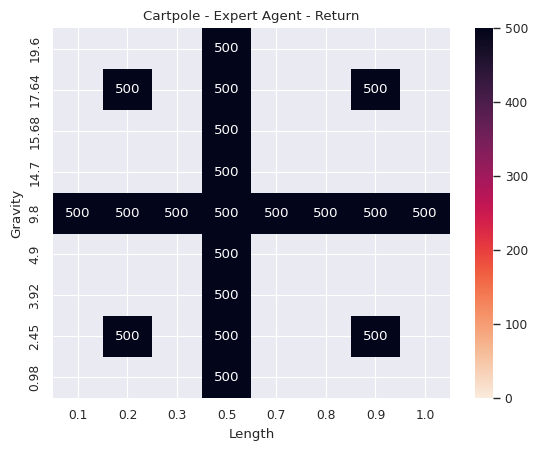

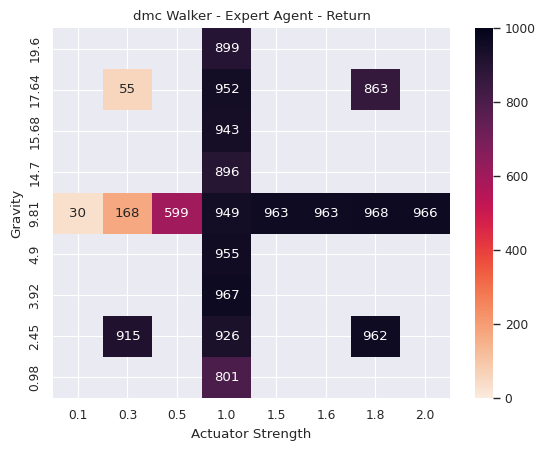

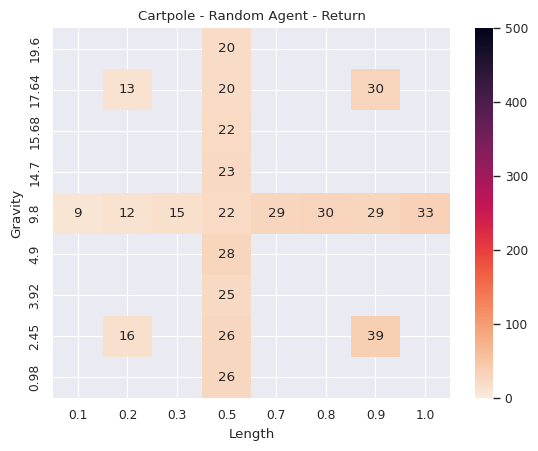

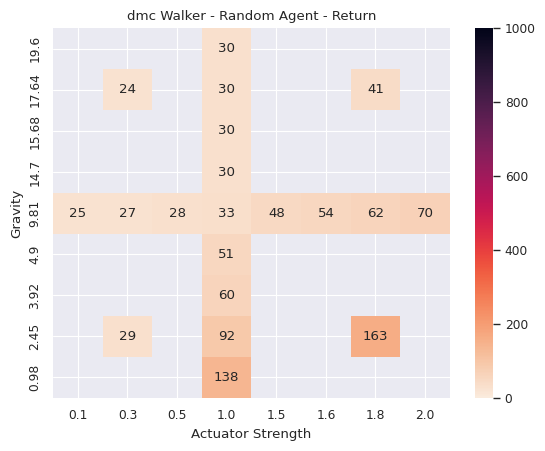

In [3]:
expert_agent_metrics, random_agent_metrics = get_expert_and_random_metrics()
save_dir = Path("./plots/")
plot_ctx_specific_metrics(expert_agent_metrics, "Expert", save_dir)
plot_ctx_specific_metrics(random_agent_metrics, "Random", save_dir)

In [13]:
import json
from pathlib import Path

from matplotlib import pyplot as plt
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
import pandas as pd
import seaborn as sns

TASK2MaxReturn = {
    "classic_cartpole": 500,
    "dmc_walker": 1000
}
sns.set_context("paper", font_scale=1.5)


def plot_bar_chart(task, context_idx, modality, save_dir, log_dir, expert_agent_metrics, random_agent_metrics, plot_y="return", suffix="50k"):
    single_setting = f"single_{context_idx}"
    
    experiments = [
        log_dir / f"carl_{task}_default_enc_{modality}_dec_{modality}_{suffix}",
        log_dir / f"carl_{task}_{single_setting}_enc_{modality}_dec_{modality}_{suffix}",
        log_dir / f"carl_{task}_{single_setting}_enc_{modality}_ctx_dec_{modality}_ctx_{suffix}",
        log_dir / f"carl_{task}_{single_setting}_enc_{modality}_dec_{modality}_pgm_ctx_{suffix}",
    ] 
    exp_types = [
        "default", "hidden-context", "concat-context", "cRSSM"
    ]
    # if (log_dir / f"carl_{task}_{single_setting}_enc_{modality}_dec_{modality}_pgm_ctx_adv_{suffix}").exists():
    #     experiments.append(log_dir / f"carl_{task}_{single_setting}_enc_{modality}_dec_{modality}_pgm_ctx_adv_{suffix}")
    #     exp_types.append("vcRSSM")
    
    modality = "Featurized Observation" if modality == "obs" else "Pixel Observation"

    context_name = _TASK2CONTEXTS[task][context_idx]["context"]
    data = {
        "Context": [],
        "Experiment": [],
        "Return": [],
    }
    seeds = 0
    for i, exp_path in enumerate(experiments):
        exp_type = exp_types[i]
        for seed_path in exp_path.iterdir():
            eval_file = seed_path / "eval.jsonl"
            if not eval_file.exists():
                continue
            seeds += 1
            with eval_file.open() as f:
                lines = f.readlines()
            lines = [json.loads(line) for line in lines if not json.loads(line)['aggregated_context_metric']]
            for line in lines:
                if context_name in line["ctx"]["changed"] and len(line["ctx"]["changed"]) == 1 or len(line["ctx"]["changed"]) == 0:
                    ctx_value = line['ctx']["context"][context_name]
                    ret = float(line['return'])
                    data["Context"].append(ctx_value)
                    data["Experiment"].append(exp_type)
                    data["Return"].append(ret)
    df = pd.DataFrame.from_dict(data)
    env = _TASK2ENV[task]

    default_context_val = env.get_default_context()[context_name]

    interpolate_range = _TASK2CONTEXTS[task][context_idx]["train_range"]
    
    
    other_ctx_id = 1 - context_idx
    other_ctx_name = _TASK2CONTEXTS[task][other_ctx_id]["context"]
    other_default = env.get_default_context()[other_ctx_name]
    best_x = []
    best_y = []
    random_y = []
    for ctx_val in expert_agent_metrics[task]:
        if ctx_val[other_ctx_id] == other_default:
            best_x.append(ctx_val[context_idx])
            best_y.append(expert_agent_metrics[task][ctx_val])
            random_y.append(random_agent_metrics[task][ctx_val])
    # for each context_val in df, find nearest best_x, and use the best_y as the regret for comparison
    best_x = np.array(best_x)
    best_y = np.array(best_y)
    random_y = np.array(random_y)
    # create a column for regret in df
    df["Regret"] = 0.
    df["Expert"] = 0.
    # iterate over df and find the nearest best_x and use the best_y as the regret for comparison
    # nearest works as we only vary one context at a time, so normalizing the context values to find nearest is not needed.
    for i, row in df.iterrows():
        ctx_val = row["Context"]
        idx = np.argmin(np.abs(best_x - ctx_val))
        df.at[i, "Best Score"] = best_y[idx]
        df.at[i, "Regret"] = best_y[idx] - row["Return"]
            
    plt.figure(figsize=(20,10))
    
    #ax = sns.violinplot(data=df, x="context", y="return", hue="experiment", cut=0, native_scale=True, density_norm="width", width=0.75)
    ax = sns.barplot(data=df, x="Context", y=plot_y, hue="Experiment", native_scale=True, errorbar='se')
    context_name = context_name.replace("_", " ").title()
    plt.xlabel(context_name)
    
    if plot_y == "Return":
        bestx_s, besty_s, random_ys = zip(*sorted(zip(best_x, best_y, random_y)))
        plt.step(bestx_s, besty_s, color='C2', linestyle=':', where='mid', label="Expert policy", lw=2)
        plt.step(bestx_s, random_ys, color='C9', linestyle='-.', where='mid', label="Random policy", lw=2)

    plt.xticks(df["Context"].unique())
    # find index of default value in df["Context"]
    default_idx = df["Context"].unique().tolist().index(default_context_val)
    ax.get_xticklabels()[default_idx].set_color('C3')
    
    # plt.axvline(default_context_val, color='C3', linestyle='--', label="default context", lw=2)
    plt.axvspan(interpolate_range[0], interpolate_range[1], facecolor='C2', alpha=0.1, label="train range")
    
    
    # set the y axis to go from 0 to max return
    plt.ylim(0, TASK2MaxReturn[task] + 10)   
    
    hatches = ["//", "\\\\", "||", "--"]
    plt.legend()
    # Loop over the bars
    for bars, hatch, handle in zip(ax.containers, hatches, ax.get_legend().legend_handles):
        # Set a different hatch for each group of bars
        handle.set_hatch(hatch)
        for bar in bars:
            bar.set_hatch(hatch)
    
    # add legend for the background
    

    # Title should be task - modality - context_name
    # bold the context name
    if task == "classic_cartpole":
        task = "Cartpole"
    elif task == "dmc_walker":
        task = "dmc Walker"
    title = f"{task} - {modality}"
    save_path = save_dir / f"{task}_{context_name}_{modality}_{plot_y}.pdf"
    plt.title(title)
    plt.savefig(save_path,bbox_inches='tight')
    plt.pause(0.1)
    if seeds != 40:
        print(experiments)
        print(f"not enough seeds - {title} - {seeds}")        

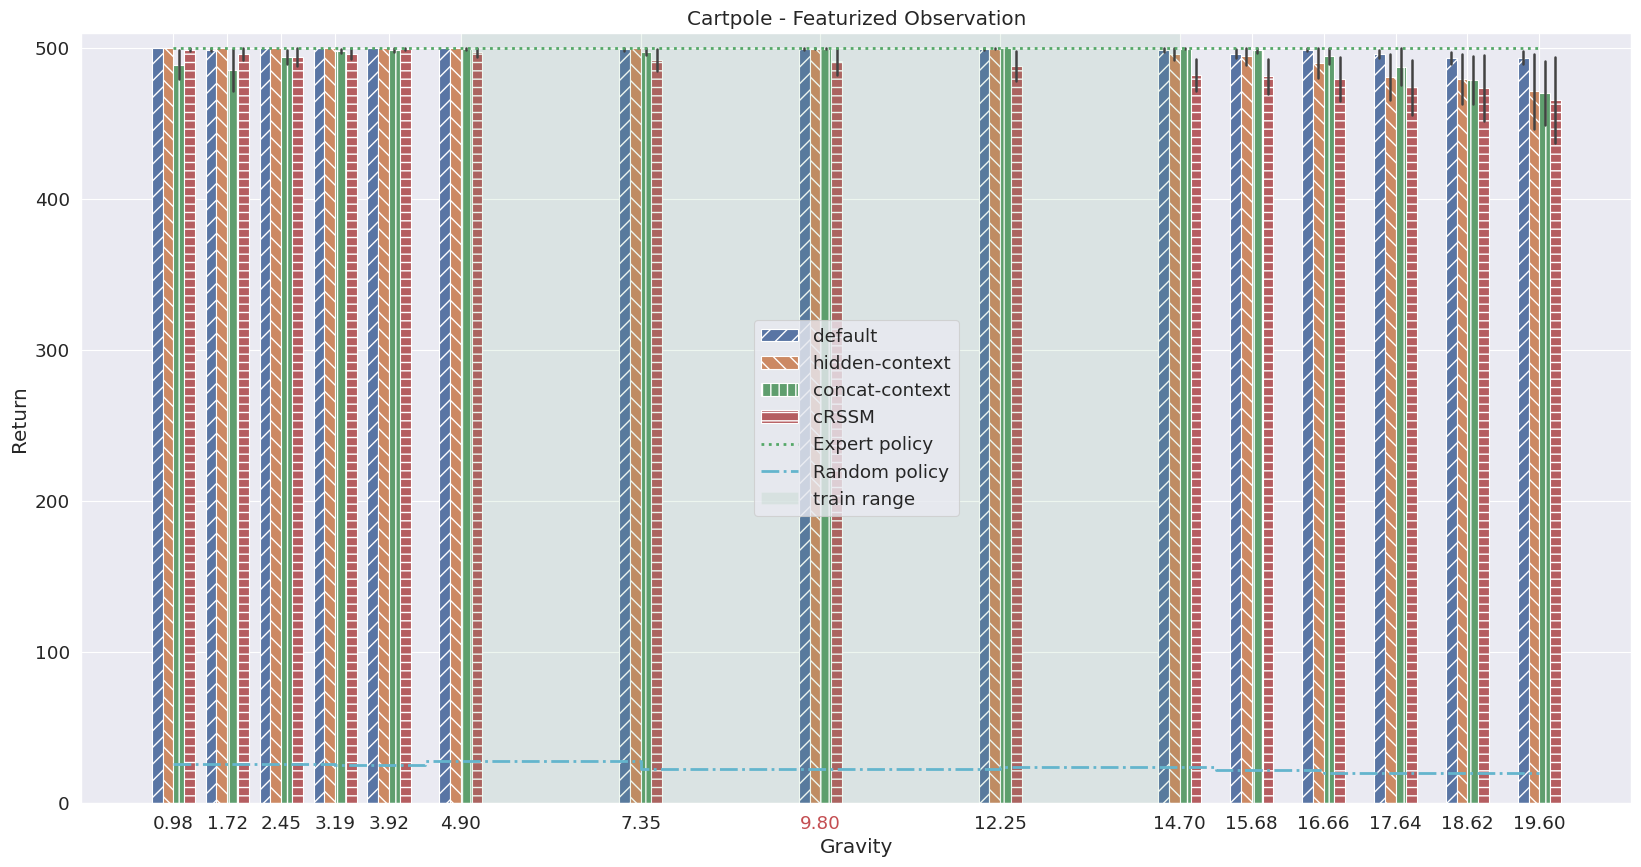

Return


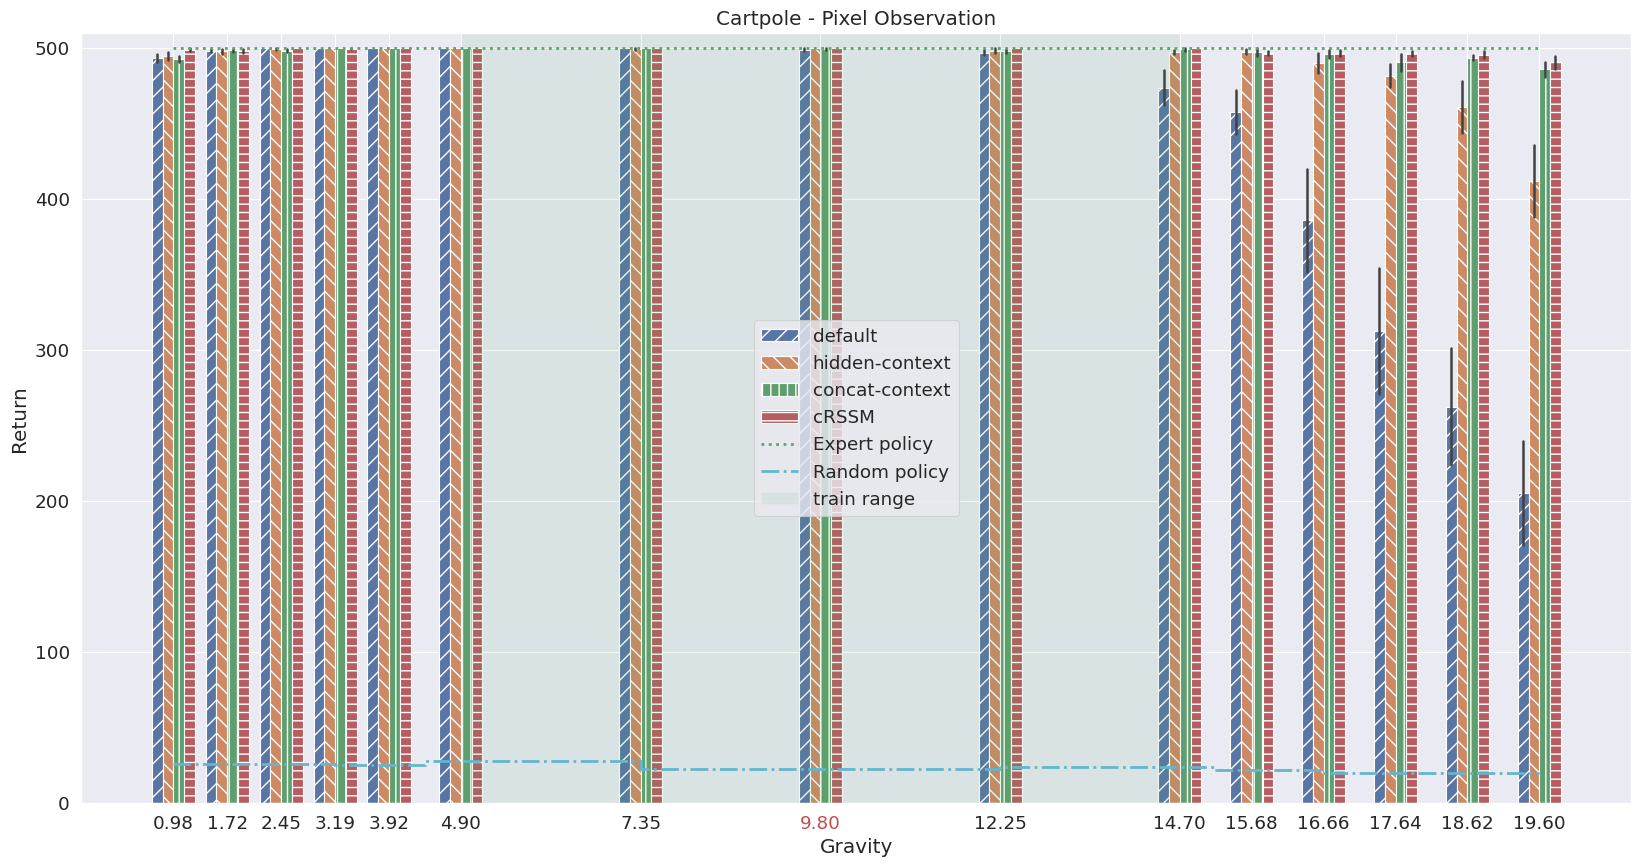

Return


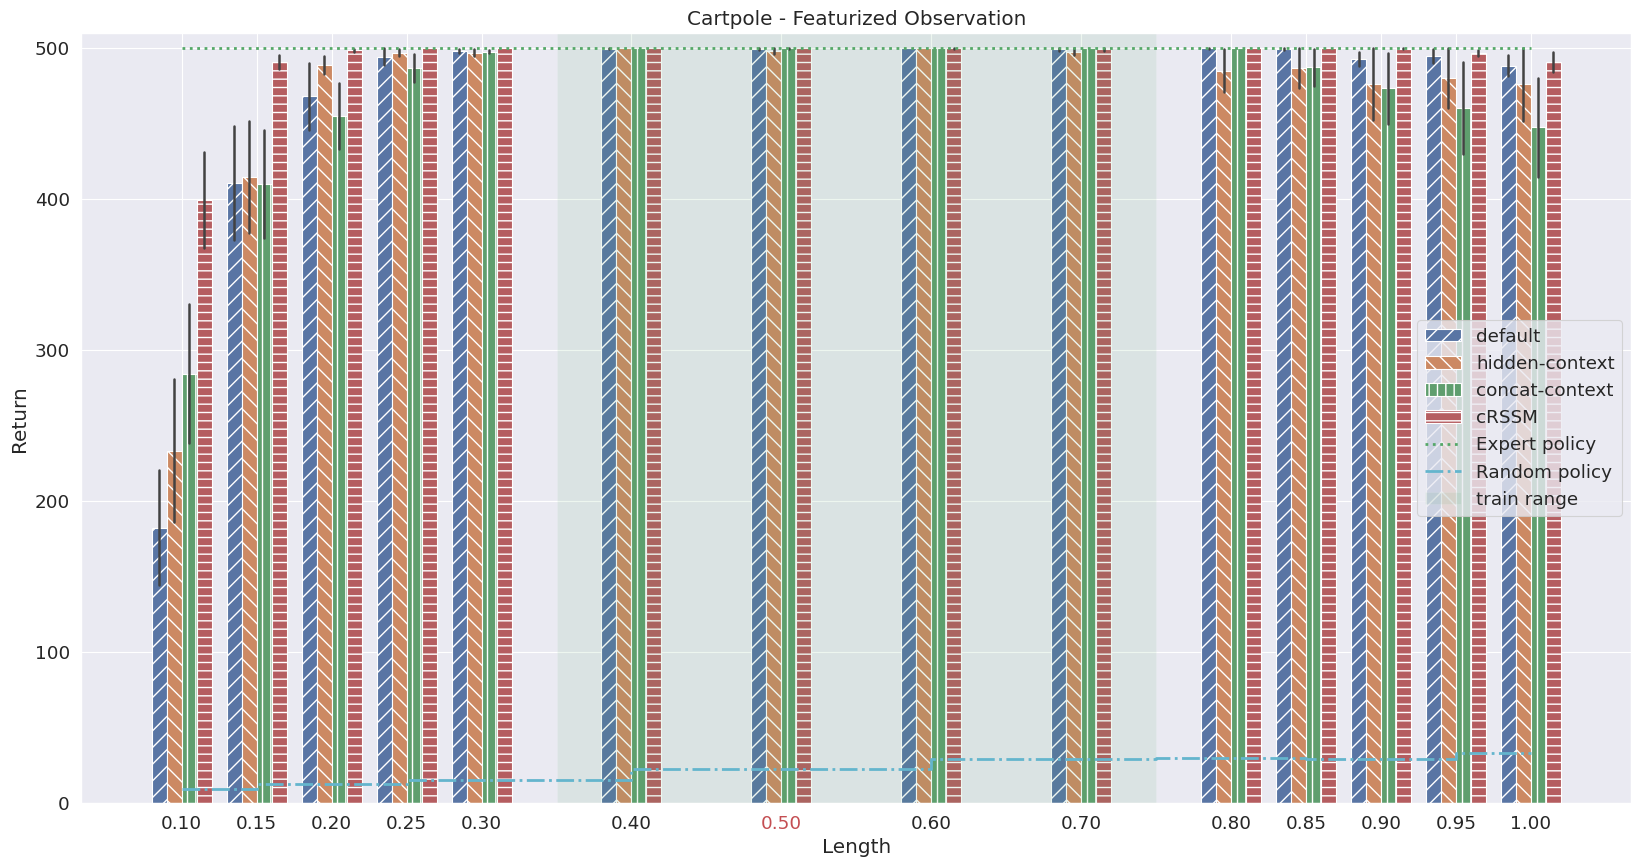

Return


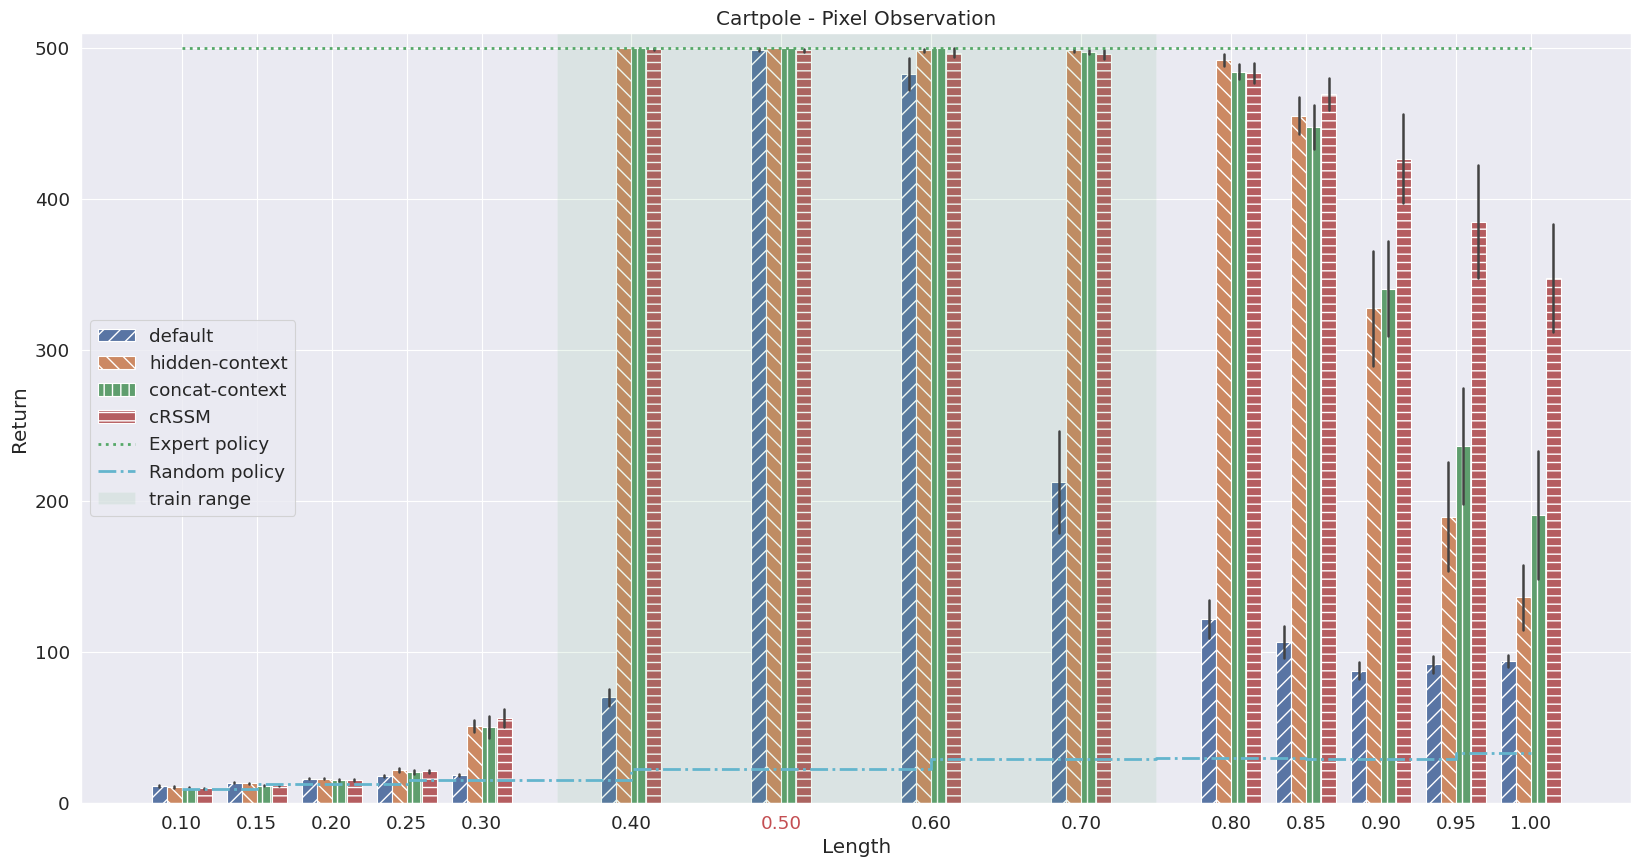

Return


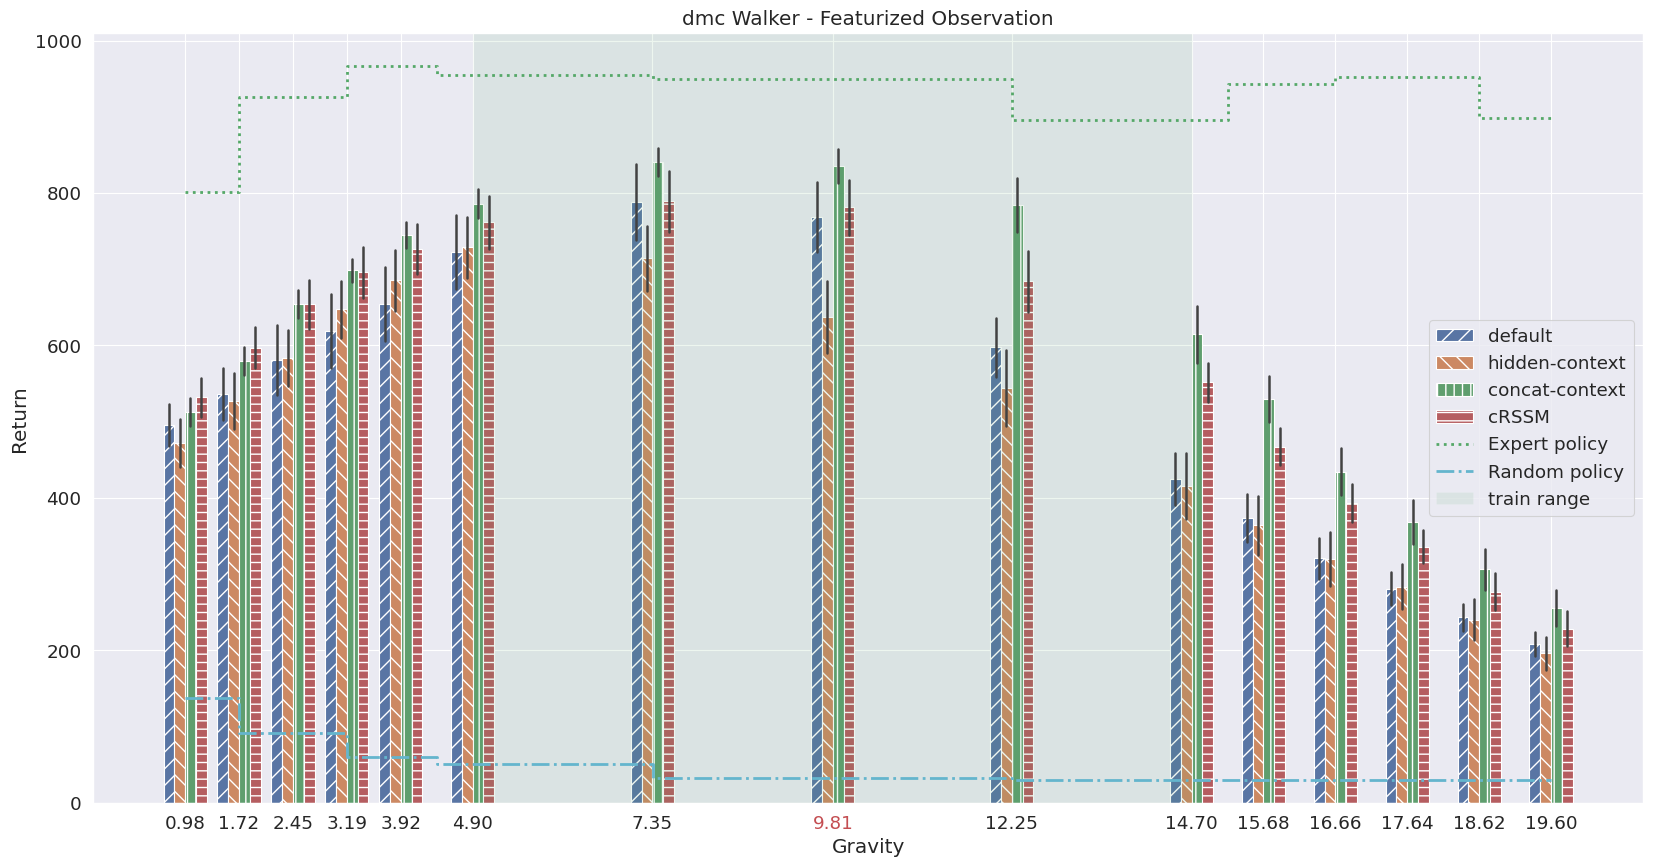

Return


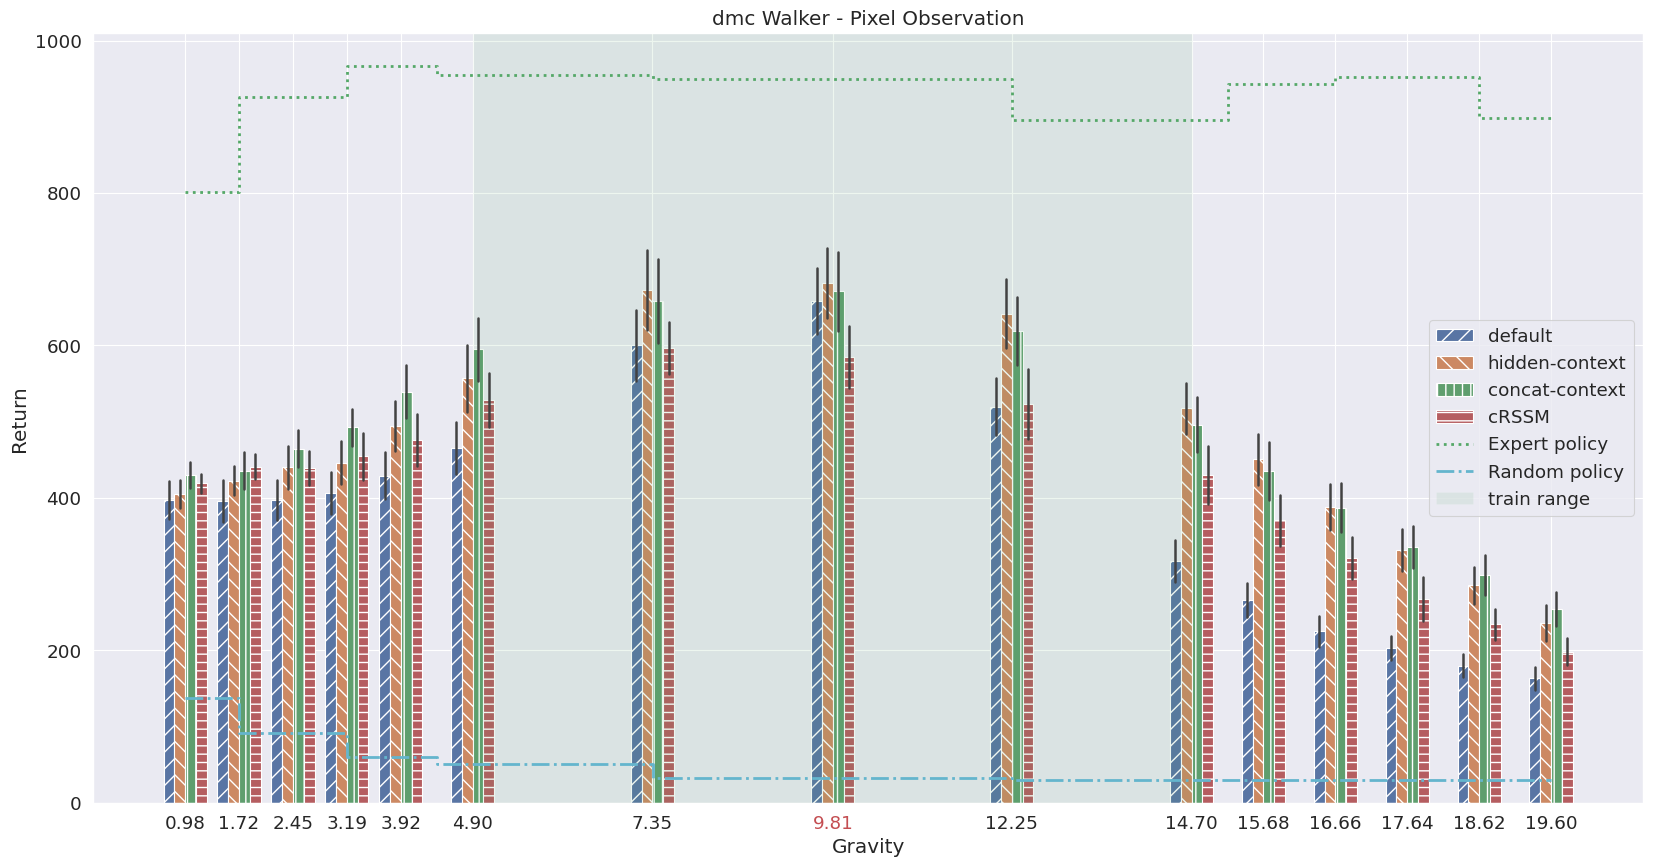

Return


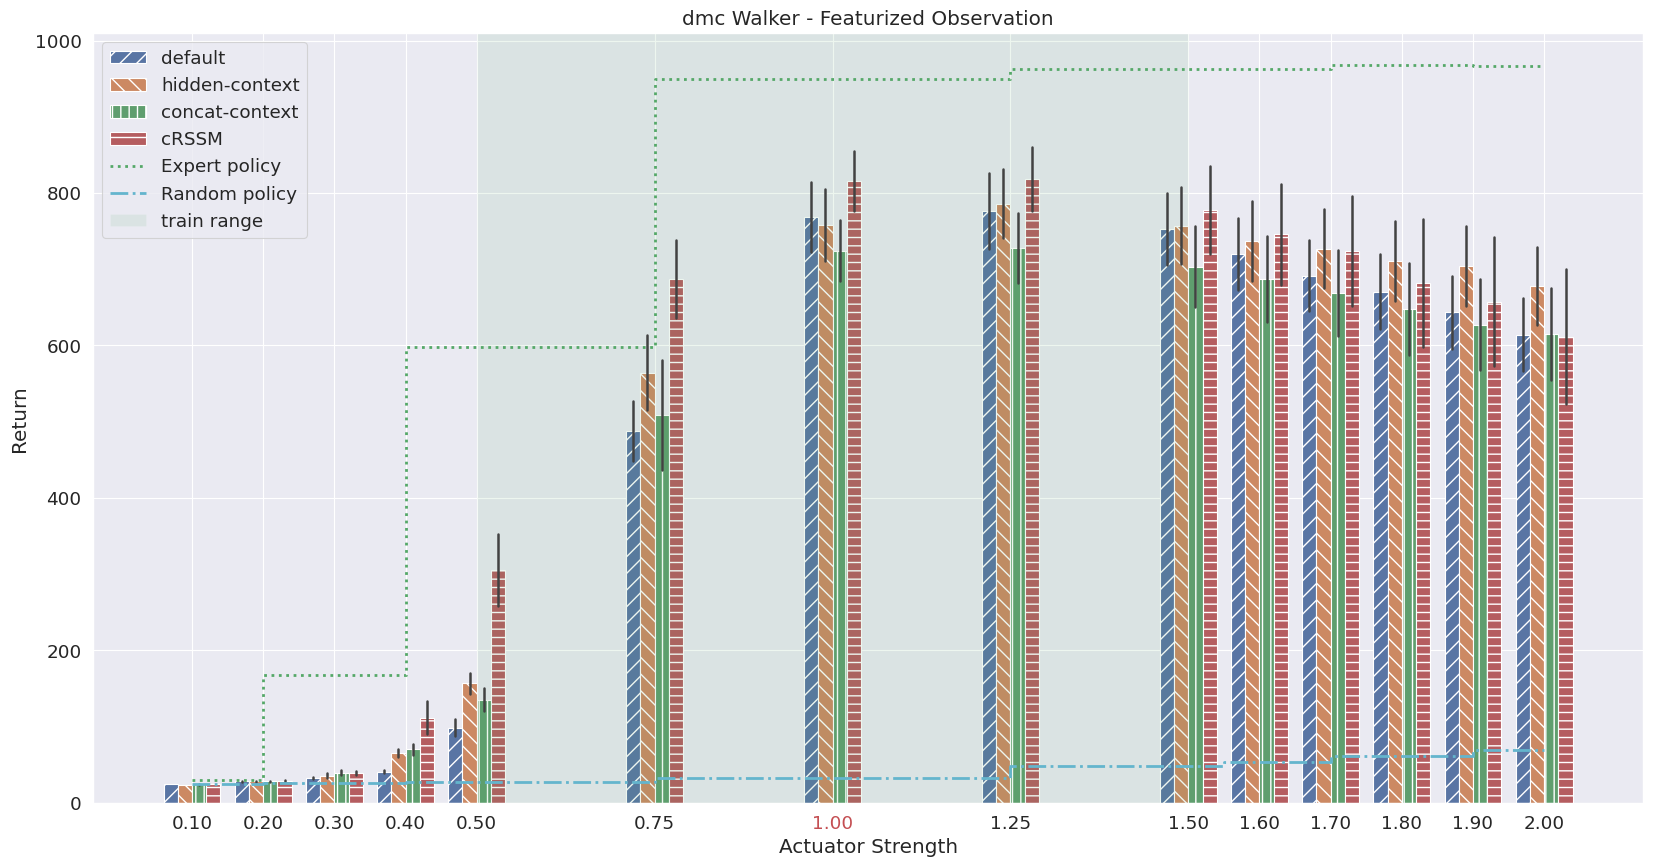

Return


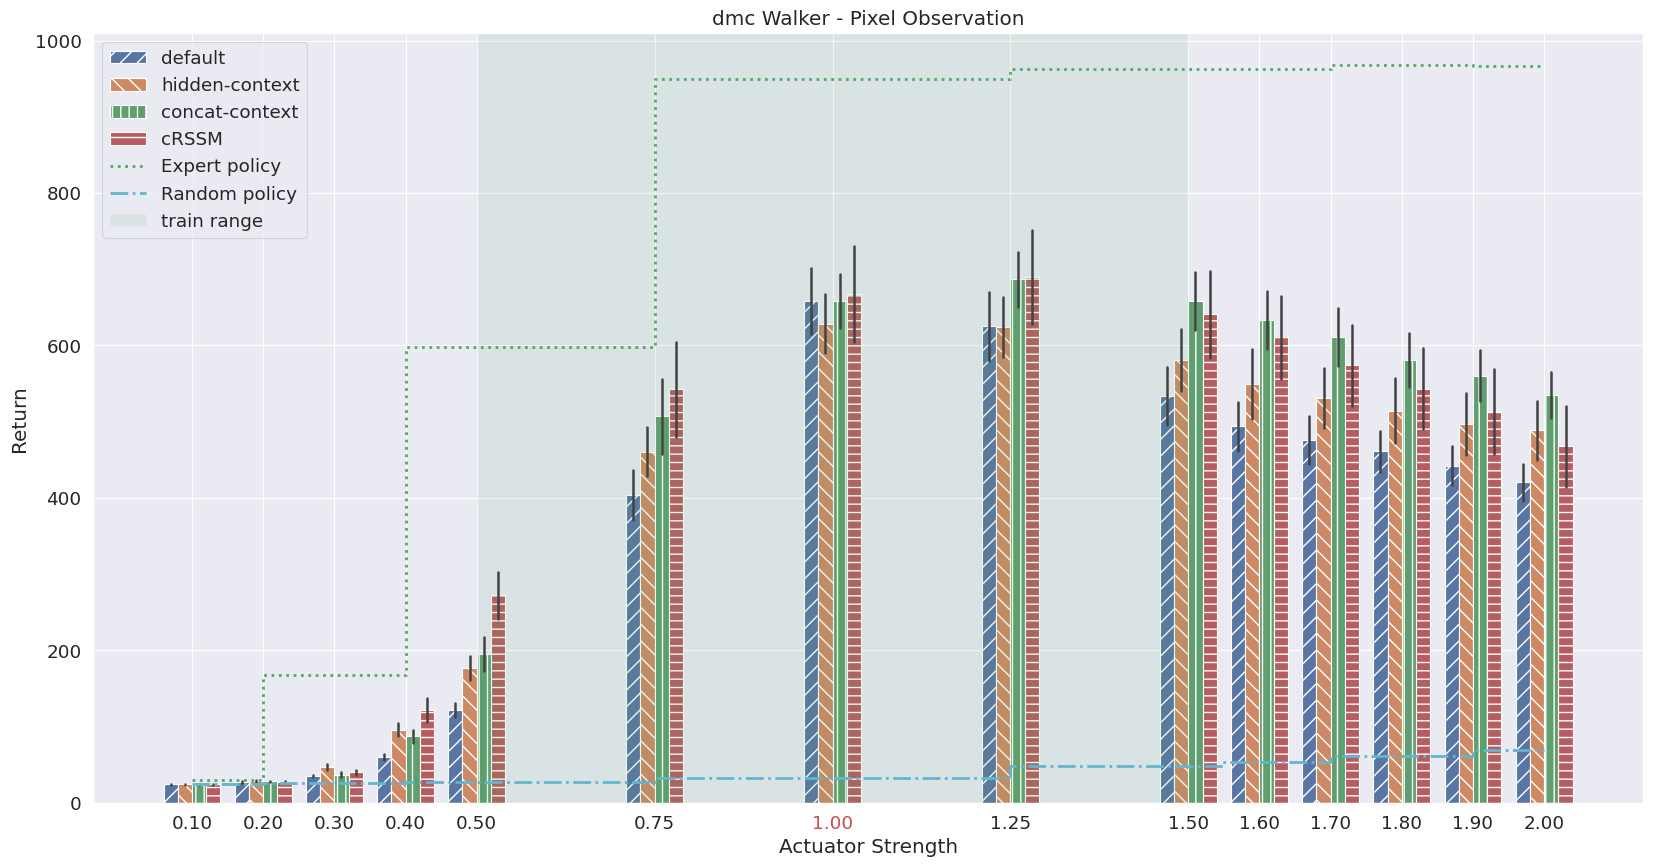

Return


In [14]:
tasks = ["classic_cartpole", "dmc_walker"]
context_ids = [0, 1]
modalities = ["obs", "img"]
logdir = Path("../logs")
save_dir = Path("./plots/")

for task in tasks:
    for context_id in context_ids:
        for modality in modalities:
            for plot_y in ["Return"]:
                plot_bar_chart(task, context_id, modality, save_dir, logdir, expert_agent_metrics, random_agent_metrics, plot_y, "normalized")
                print(plot_y)

In [6]:
import json
from pathlib import Path

from matplotlib import pyplot as plt
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import cdist
import numpy as np
from scipy.stats import sem
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils


def match_and_normalize_metrics(agent_metrics, expert_metrics, random_metrics):
    normalized_metrics = {}
    min_ctx_0 = min([k[0] for k in agent_metrics])
    max_ctx_0 = max([k[0] for k in agent_metrics])
    min_ctx_1 = min([k[1] for k in agent_metrics])
    max_ctx_1 = max([k[1] for k in agent_metrics])
    normalized_best_keys = [
        ((k[0] - min_ctx_0) / (max_ctx_0 - min_ctx_0 + 1e-6), (k[1] - min_ctx_1) / (max_ctx_1 - min_ctx_1 + 1e-6)) for k in expert_metrics
    ]
    best_keys = list(expert_metrics.keys())
    
    for current_key, returns in agent_metrics.items():
        normalized_current_key = ((current_key[0] - min_ctx_0) / (max_ctx_0 - min_ctx_0 + 1e-6), (current_key[1] - min_ctx_1) / (max_ctx_1 - min_ctx_1 + 1e-6))
        distances = cdist([normalized_current_key], normalized_best_keys)
        nearest_index = np.argmin(distances)
        nearest_key = best_keys[nearest_index]
        normalized_metrics[current_key] = (returns - random_metrics[nearest_key]) / (expert_metrics[nearest_key] - random_metrics[nearest_key])
    return normalized_metrics

def compute_iqm_summary(log_dir, task, train_setting, context_idx, modality, ctx_type, expert_metrics, random_metrics,  suffix):
    assert train_setting in ["default", "single", "double_box"]
    assert train_setting != "double_box" or context_idx is None
    train_setting_full = train_setting
    metric_context_name = None
    if train_setting == "single":
        train_setting_full = f"{train_setting}_{context_idx}"
    if context_idx is not None:
        metric_context_name = _TASK2CONTEXTS[task][context_idx]["context"]

    
    if ctx_type == "no_ctx":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_dec_{modality}_{suffix}"
        ctx_type = "no context"
    elif ctx_type == "enc_dec_ctx":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_ctx_dec_{modality}_ctx_{suffix}"
        ctx_type = "Concat Context"
    elif ctx_type == "pgm_ctx":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_dec_{modality}_pgm_ctx_{suffix}"
        ctx_type = "cRSSM"
    elif ctx_type == "pgm_ctx_adv":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_dec_{modality}_pgm_ctx_adv_{suffix}"
        ctx_type = "vcRSSM"
    else:
        raise RuntimeError("invalid ctx")
    if not exp_path.exists():
        return None

    modality = "featurized" if modality == "obs" else "pixel"
    ctx_0 = _TASK2CONTEXTS[task][0]["context"]
    ctx_1 = _TASK2CONTEXTS[task][1]["context"]
    env = _TASK2ENV[task]
    default_0 = env.get_default_context()[ctx_0]
    default_1 = env.get_default_context()[ctx_1]
    current_metrics = defaultdict(list)
    for seed_path in exp_path.iterdir():
        eval_file = seed_path / "eval.jsonl"
        if not eval_file.exists():
            continue
        with eval_file.open() as f:
            lines = f.readlines()
        lines = [json.loads(line) for line in lines if not json.loads(line)['aggregated_context_metric']]
        if len(lines) != 84:
            continue
        for line in lines:
            ctx_0_val, ctx_1_val = line['ctx']["context"][ctx_0], line['ctx']["context"][ctx_1]
            ret = float(line['return'])
            if train_setting == "double_box" or (train_setting == "default" and context_idx is None)  or (metric_context_name in line["ctx"]["changed"] and len(line["ctx"]["changed"]) == 1 or len(line["ctx"]["changed"]) == 0):
                current_metrics[(ctx_0_val, ctx_1_val)].append(ret)
    agent_metrics = {k: np.array(v) for k, v in current_metrics.items()}
    normalized_agent_metrics = match_and_normalize_metrics(agent_metrics, expert_metrics[task], random_metrics[task])
    interpolate_ranges = [
        [default_0 - 1e-6, default_0 + 1e-6],
        [default_1 - 1e-6, default_1 + 1e-6]
    ]
    
    if context_idx is not None:
        interpolate_ranges[context_idx] = _TASK2CONTEXTS[task][context_idx]["train_range"]
    else:
        interpolate_ranges[0] = _TASK2CONTEXTS[task][0]["train_range"]
        interpolate_ranges[1] = _TASK2CONTEXTS[task][1]["train_range"]
    
    interpolate_return = []
    extrapolate_return = []
    inter_extrapolate_return = []
    
    for ctx_key in normalized_agent_metrics:
        if (ctx_key[0] >= interpolate_ranges[0][0] and ctx_key[0] <= interpolate_ranges[0][1]) and (ctx_key[1] >= interpolate_ranges[1][0] and ctx_key[1] <= interpolate_ranges[1][1]):
            interpolate_return.append(normalized_agent_metrics[ctx_key])   
        elif context_idx is not None or (ctx_key[0] < interpolate_ranges[0][0] or ctx_key[0] > interpolate_ranges[0][1]) and (ctx_key[1] < interpolate_ranges[1][0] or ctx_key[1] > interpolate_ranges[1][1]):
        # elif train_setting != "double_box" or (ctx_key[0] < interpolate_ranges[0][0] or ctx_key[0] > interpolate_ranges[0][1]) and (ctx_key[1] < interpolate_ranges[1][0] or ctx_key[1] > interpolate_ranges[1][1]):
            extrapolate_return.append(normalized_agent_metrics[ctx_key])
        else:
            inter_extrapolate_return.append(normalized_agent_metrics[ctx_key])
    
    interpolate_iqm = metrics.aggregate_iqm(np.array(interpolate_return).T)
    extrapolate_iqm = metrics.aggregate_iqm(np.array(extrapolate_return).T)
    inter_extrapolate_iqm = metrics.aggregate_iqm(np.array(inter_extrapolate_return).T)
    if task == "classic_cartpole":
        task = "Cartpole"
    elif task == "dmc_walker":
        task = "dmc Walker"
    return (task, train_setting, metric_context_name or f'{ctx_0},{ctx_1}', modality, ctx_type,
            interpolate_iqm, extrapolate_iqm, inter_extrapolate_iqm
        )

In [7]:
print(compute_iqm_summary(Path("../logs"), "dmc_walker", "double_box", None, "img", "pgm_ctx", expert_agent_metrics, random_agent_metrics, "500k"))
print(compute_iqm_summary(Path("../logs"), "dmc_walker", "double_box", None, "img", "no_ctx", expert_agent_metrics, random_agent_metrics, "500k"))
print(compute_iqm_summary(Path("../logs"), "dmc_walker", "double_box", None, "img", "enc_dec_ctx", expert_agent_metrics, random_agent_metrics, "500k"))

('dmc Walker', 'double_box', 'gravity,actuator_strength', 'pixel', 'cRSSM', 1.0038906394929263, 0.7280890998728, 0.8994344769680582)
('dmc Walker', 'double_box', 'gravity,actuator_strength', 'pixel', 'no context', 0.9771235799576298, 0.64809836613492, 0.7987461171452651)
('dmc Walker', 'double_box', 'gravity,actuator_strength', 'pixel', 'Concat Context', 0.9921758979001994, 0.7590418499843512, 0.8785228092276722)


In [8]:
tasks = ["classic_cartpole", "dmc_walker"]
train_settings = ["default", "single", "double_box"] # default context, varying single context in a interpolation range 
context_ids = [0, 1]
modalities = ["obs", "img"]
logdir = Path("../logs")
save_dir = Path("./plots/")
df = pd.DataFrame(columns=["Task", "Train Setting", "Context", "Modality", "Inputs",  "Interpolate IQM", "Extrapolate IQM", "Inter-Extra IQM"])
import warnings
for task in tasks:
    for setting in ["single", "double_box"]:
        if setting == "single":
            context_ids = [0, 1]
        else:
            context_ids = [None]
        for ctx_id in context_ids:
            for modality in modalities:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    row = compute_iqm_summary(logdir, task, "default", ctx_id, modality, "no_ctx", expert_agent_metrics, random_agent_metrics, "normalized")
                    df.loc[len(df)] = row
                    for ctx_type in ["no_ctx", "enc_dec_ctx", "pgm_ctx"]:
                        row = compute_iqm_summary(logdir, task, setting, ctx_id, modality, ctx_type, expert_agent_metrics, random_agent_metrics, "normalized")
                        if row:
                            df.loc[len(df)] = row
# replace NaN with "N/A"

df = df.fillna("N/A")
df.to_csv(save_dir / f"iqm.csv", index=False)

In [9]:
import json

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle

sns.set_context("paper", font_scale=1.0)
def plot2d(logdir, save_dir, task, modality, train_mode, ctx, plot_key, exp_suffix):

    data = defaultdict(list)

    ctx_0 = _TASK2CONTEXTS[task][0]["context"]
    ctx_1 = _TASK2CONTEXTS[task][1]["context"]

    if train_mode == "default":
        env = _TASK2ENV[task]
        default_0 = env.get_default_context()[ctx_0]
        default_1 = env.get_default_context()[ctx_1]
        interpolate_range_0 = [default_0, default_0]
        interpolate_range_1 = [default_1, default_1]
    else:
        interpolate_range_0 = _TASK2CONTEXTS[task][0]["train_range"]
        interpolate_range_1 = _TASK2CONTEXTS[task][1]["train_range"]

    if ctx == "no_ctx":
        exp_path = logdir / f"carl_{task}_{train_mode}_enc_{modality}_dec_{modality}_{exp_suffix}"
        ctx_text = "hidden-context"
    elif ctx == "enc_dec_ctx":
        exp_path = logdir / f"carl_{task}_{train_mode}_enc_{modality}_ctx_dec_{modality}_ctx_{exp_suffix}"
        ctx_text = "concat-context"
    elif ctx == "pgm_ctx":
        exp_path = logdir / f"carl_{task}_{train_mode}_enc_{modality}_dec_{modality}_pgm_ctx_{exp_suffix}"
        ctx_text = "cRSSM"
    elif ctx == "pgm_ctx_adv":
        exp_path = logdir / f"carl_{task}_{train_mode}_enc_{modality}_dec_{modality}_pgm_ctx_adv_{exp_suffix}"
        ctx_text = "dcRSSM"
    modality = "Featurized observation" if modality == "obs" else "Pixel observation"
    seeds = 0
    experiment = exp_path.name
    for seed_path in exp_path.iterdir():
        seed = int(seed_path.name)
        eval_file = seed_path / "eval.jsonl"
        if not eval_file.exists():
            continue
        seeds += 1
        with eval_file.open() as f:
            lines = f.readlines()
        lines = [json.loads(line) for line in lines if not json.loads(line)['aggregated_context_metric']]
        for line in lines:
            
            ctx_0_value = line['ctx']["context"][ctx_0]
            ctx_1_value = line['ctx']["context"][ctx_1]
            ret = float(line['return'])
            data[(ctx_0_value, ctx_1_value)].append(ret)


    min_ctx_0 = min([k[0] for k in data])
    max_ctx_0 = max([k[0] for k in data])
    min_ctx_1 = min([k[1] for k in data])
    max_ctx_1 = max([k[1] for k in data])
    normalized_best_keys = [
        ((k[0] - min_ctx_0) / (max_ctx_0 - min_ctx_0 + 1e-6), (k[1] - min_ctx_1) / (max_ctx_1 - min_ctx_1 + 1e-6)) for k in expert_agent_metrics[task]
    ]
    
    x = []
    y = []
    c = []
    mean_regret = []
    for ctx_0_value, ctx_1_value in data:
        x.append(ctx_0_value)
        y.append(ctx_1_value)
        c.append(np.mean(data[(ctx_0_value, ctx_1_value)]))
        normalized_key = ((ctx_0_value - min_ctx_0) / (max_ctx_0 - min_ctx_0 + 1e-6), (ctx_1_value - min_ctx_1) / (max_ctx_1 - min_ctx_1 + 1e-6))
        distances = cdist([normalized_key], normalized_best_keys)
        nearest_index = np.argmin(distances)
        nearest_key = list(expert_agent_metrics[task].keys())[nearest_index]
        nearest_best_return = expert_agent_metrics[task][nearest_key]
        mean_regret.append(nearest_best_return - np.mean(data[(ctx_0_value, ctx_1_value)]))

    ctx_0 = ctx_0.replace("_", " ").title()
    ctx_1 = ctx_1.replace("_", " ").title()

    df = pd.DataFrame({ctx_0: x, ctx_1: y, "return": c, "regret": mean_regret})
    df = df.pivot(index=ctx_0, columns=ctx_1, values=plot_key)
    
    # sort the rows descending
    df = df.sort_index(ascending=False)

    
    # darker colors for higher values, red color map
    ax = sns.heatmap(df, cmap=sns.cm.rocket_r if plot_key == "return" else sns.cm.crest_r, annot=True, fmt=".0f")
    

    h_index_0 = df.index.searchsorted(interpolate_range_0[0], 'left', df.index.argsort())
    h_index_1 = df.index.searchsorted(interpolate_range_0[1], 'right', df.index.argsort())

    v_index_0 = df.columns.searchsorted(interpolate_range_1[0], 'left')
    v_index_1 = df.columns.searchsorted(interpolate_range_1[1], 'right')
    
    ax.add_patch(Rectangle((v_index_0, h_index_0), (v_index_1 - v_index_0), (h_index_1 - h_index_0), fill=False, edgecolor='g', linestyle='--', linewidth=2))
    if task == "classic_cartpole":
        task = "Cartpole"
    elif task == "dmc_walker":
        task = "dmc Walker"
    
    
    plt.title(f"{task} - {modality} - {ctx_text} - {plot_key.title()}")
    
    plt.savefig(save_dir / f"{task}_{train_mode}_{modality}_{ctx}_{plot_key}.pdf",bbox_inches='tight')
    
    if seeds != 10:
        print(f"not enough seeds - {task} - {modality} - {ctx} - {seeds}")
    
    # clear plt
    plt.pause(0.1)
    return df

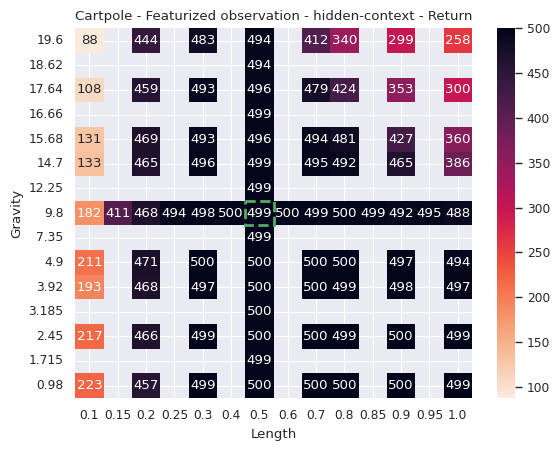

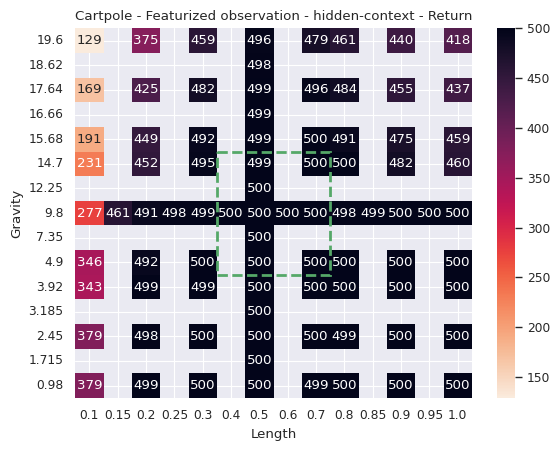

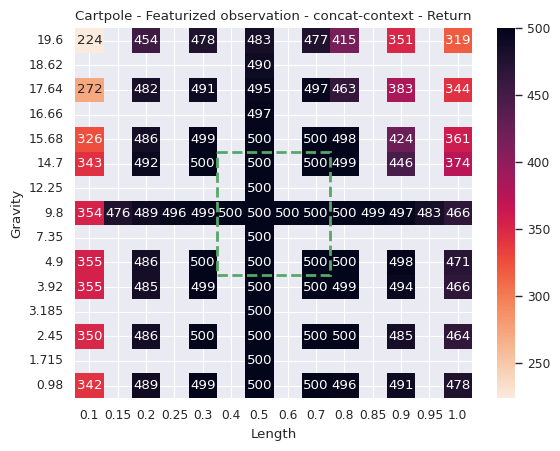

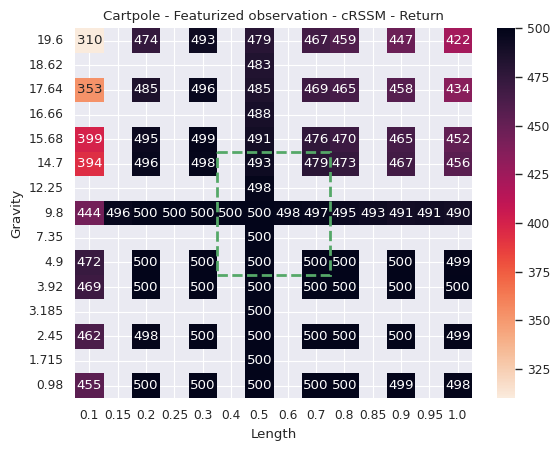

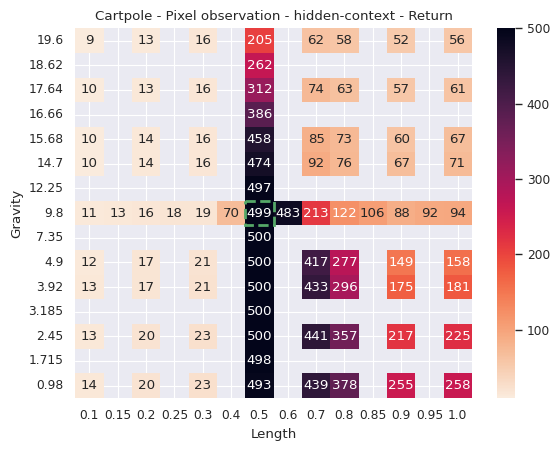

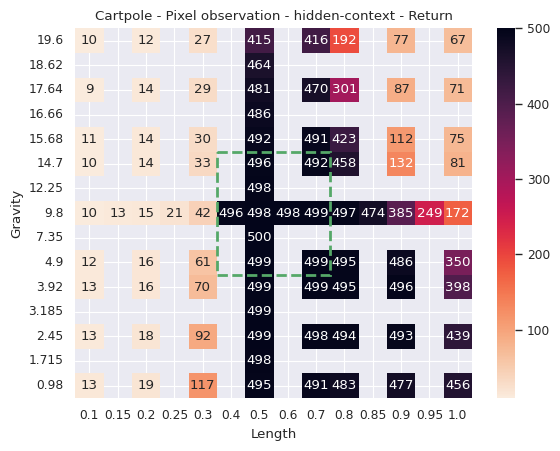

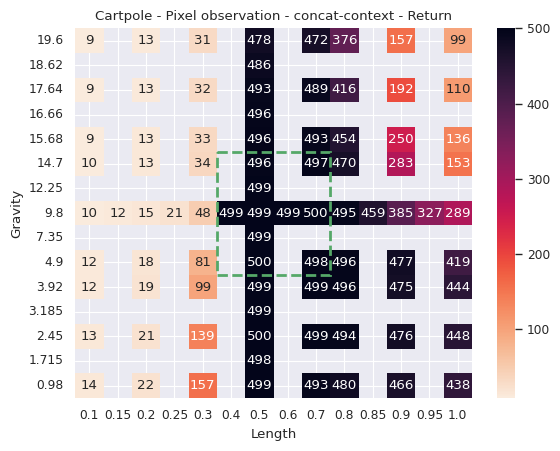

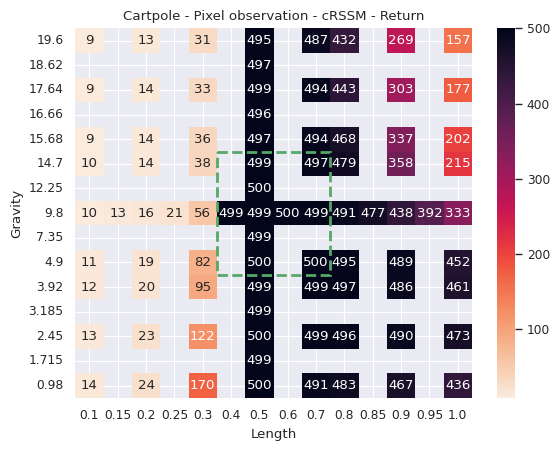

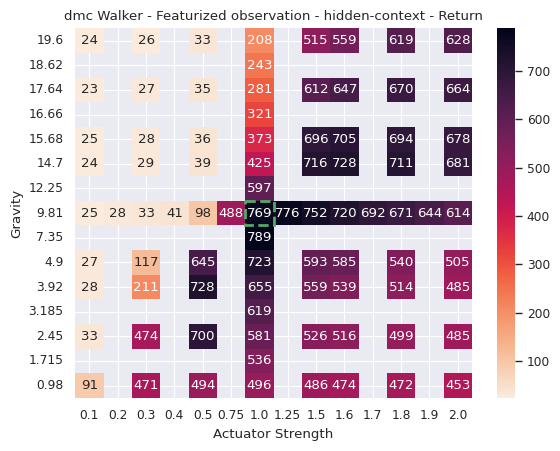

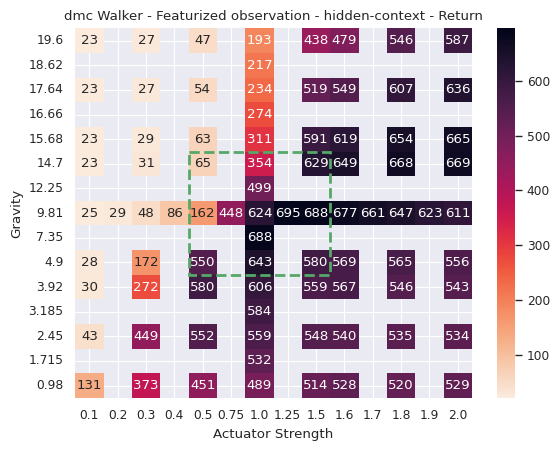

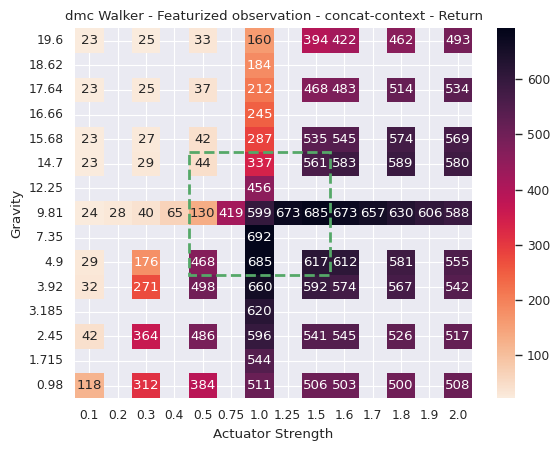

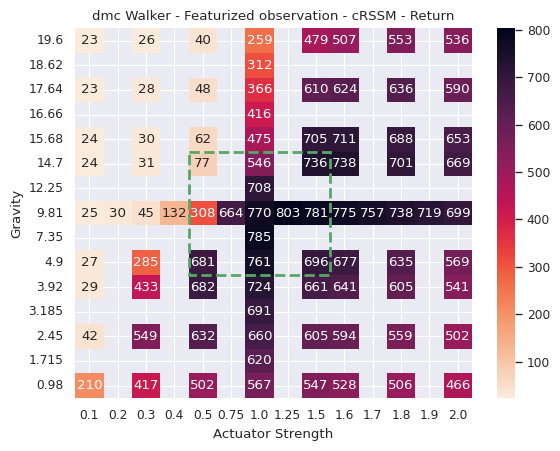

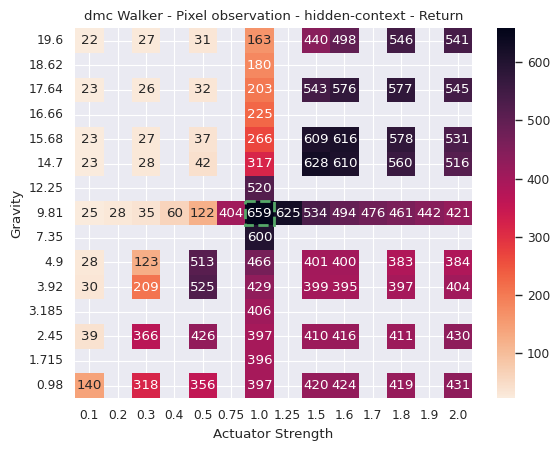

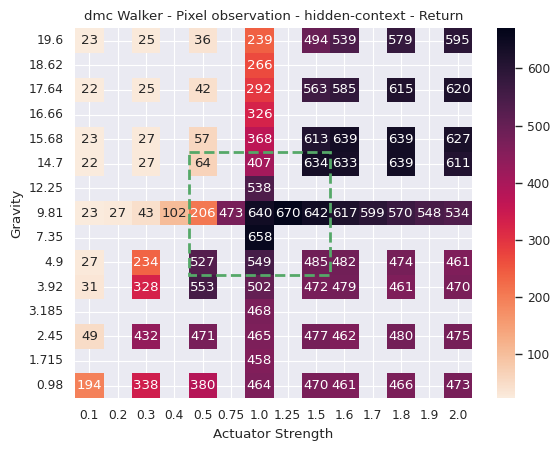

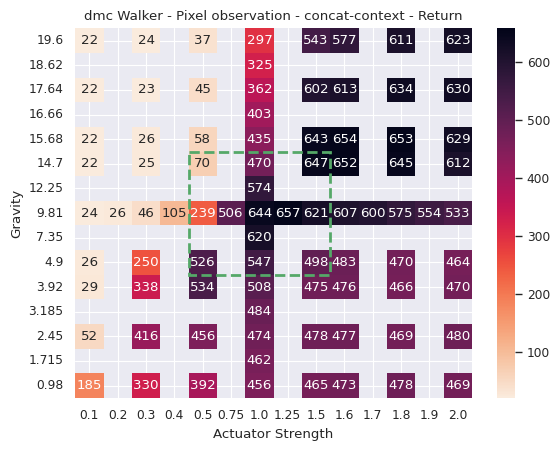

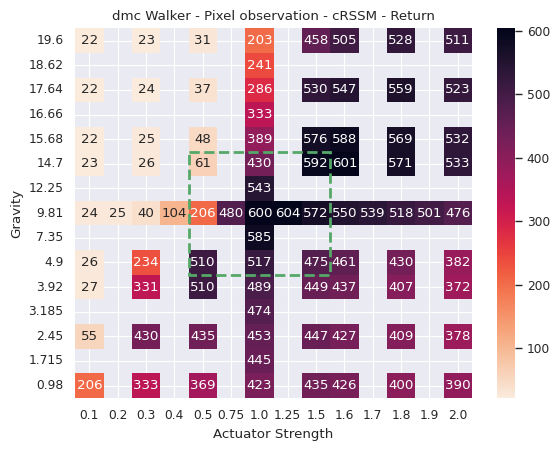

In [10]:
exp_suffix = "normalized"
tasks = ["classic_cartpole", "dmc_walker"]
modalities = ["obs", "img"]
train_modes = ["default", "double_box"]
logdir = Path("../logs") 

save_dir = Path("./plots/")
for task in tasks:
    for modality in modalities:
        for train_mode in train_modes:
            plot2d(logdir, save_dir, task, modality, train_mode, "no_ctx", "return", exp_suffix)
            # plot2d(logdir, save_dir, task, modality, train_mode, "no_ctx", "regret", exp_suffix)
            if train_mode == "double_box":
                plot2d(logdir, save_dir, task, modality, train_mode, "enc_dec_ctx", "return", exp_suffix)
                # plot2d(logdir, save_dir, task, modality, train_mode, "enc_dec_ctx", "regret", exp_suffix)         
                plot2d(logdir, save_dir, task, modality, train_mode, "pgm_ctx", "return", exp_suffix)
                # plot2d(logdir, save_dir, task, modality, train_mode, "pgm_ctx", "regret", exp_suffix)
                # plot2d(logdir, save_dir, task, modality, train_mode, "pgm_ctx_adv", "return", exp_suffix)
                # plot2d(logdir, save_dir, task, modality, train_mode, "pgm_ctx_adv", "regret", exp_suffix)     


In [11]:
import json
from pathlib import Path

from matplotlib import pyplot as plt
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import cdist
import numpy as np
from scipy.stats import sem

def compute_regret(agent_metrics, expert_agent_metrics):
    regret = {}
    min_ctx_0 = min([k[0] for k in agent_metrics])
    max_ctx_0 = max([k[0] for k in agent_metrics])
    min_ctx_1 = min([k[1] for k in agent_metrics])
    max_ctx_1 = max([k[1] for k in agent_metrics])
    normalized_best_keys = [
        ((k[0] - min_ctx_0) / (max_ctx_0 - min_ctx_0 + 1e-6), (k[1] - min_ctx_1) / (max_ctx_1 - min_ctx_1 + 1e-6)) for k in expert_agent_metrics
    ]
    best_keys = list(expert_agent_metrics.keys())
    
    for current_key, returns in agent_metrics.items():
        normalized_current_key = ((current_key[0] - min_ctx_0) / (max_ctx_0 - min_ctx_0 + 1e-6), (current_key[1] - min_ctx_1) / (max_ctx_1 - min_ctx_1 + 1e-6))
        distances = cdist([normalized_current_key], normalized_best_keys)
        nearest_index = np.argmin(distances)
        nearest_key = best_keys[nearest_index]
        nearest_best_return = expert_agent_metrics[nearest_key]
        regret[current_key] = nearest_best_return - returns
    return regret

def compute_regret_return_summary(log_dir, task, train_setting, context_idx, modality, ctx_type, expert_agent_metrics,  t_step="50k", n_best=10):
    assert train_setting in ["default", "single", "double_box"]
    assert train_setting != "double_box" or context_idx is None
    train_setting_full = train_setting
    metric_context_name = None
    if train_setting == "single":
        train_setting_full = f"{train_setting}_{context_idx}"
    if context_idx is not None:
        metric_context_name = _TASK2CONTEXTS[task][context_idx]["context"]

    
    if ctx_type == "no_ctx":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_dec_{modality}_{t_step}"
        ctx_type = "hidden-context"
    elif ctx_type == "enc_dec_ctx":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_ctx_dec_{modality}_ctx_{t_step}"
        ctx_type = "concat-context"
    elif ctx_type == "pgm_ctx":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_dec_{modality}_pgm_ctx_{t_step}"
        ctx_type = "cRSSM"
    elif ctx_type == "pgm_ctx_adv":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_dec_{modality}_pgm_ctx_adv_{t_step}"
        ctx_type = "d-cRSSM"
    else:
        raise RuntimeError("invalid ctx")
    if not exp_path.exists():
        return None

    modality = "featurized" if modality == "obs" else "pixel"
    ctx_0 = _TASK2CONTEXTS[task][0]["context"]
    ctx_1 = _TASK2CONTEXTS[task][1]["context"]
    env = _TASK2ENV[task]
    default_0 = env.get_default_context()[ctx_0]
    default_1 = env.get_default_context()[ctx_1]
    current_metrics = defaultdict(list)
    for seed_path in exp_path.iterdir():
        eval_file = seed_path / "eval.jsonl"
        if not eval_file.exists():
            continue
        with eval_file.open() as f:
            lines = f.readlines()
        lines = [json.loads(line) for line in lines if not json.loads(line)['aggregated_context_metric']]
        if len(lines) != 84:
            continue
        for line in lines:
            ctx_0_val, ctx_1_val = line['ctx']["context"][ctx_0], line['ctx']["context"][ctx_1]
            ret = float(line['return'])
            if train_setting == "double_box" or (train_setting == "default" and context_idx is None)  or (metric_context_name in line["ctx"]["changed"] and len(line["ctx"]["changed"]) == 1 or len(line["ctx"]["changed"]) == 0):
                current_metrics[(ctx_0_val, ctx_1_val)].append(ret)
    agent_metrics = {k: np.array(v) for k, v in current_metrics.items()}
    regrets = {}
    best_metrics = expert_agent_metrics[task]
    regrets = compute_regret(agent_metrics, best_metrics)
    

    interpolate_ranges = [
        [default_0 - 1e-6, default_0 + 1e-6],
        [default_1 - 1e-6, default_1 + 1e-6]
    ]
    
    if context_idx is not None:
        interpolate_ranges[context_idx] = _TASK2CONTEXTS[task][context_idx]["train_range"]
    else:
        interpolate_ranges[0] = _TASK2CONTEXTS[task][0]["train_range"]
        interpolate_ranges[1] = _TASK2CONTEXTS[task][1]["train_range"]
    
    interpolate_regret = []
    extrapolate_regret = []
    inter_extrapolate_regret = []
    interpolate_return = []
    extrapolate_return = []
    inter_extrapolate_return = []
    
    for ctx_key in regrets:
        if (ctx_key[0] >= interpolate_ranges[0][0] and ctx_key[0] <= interpolate_ranges[0][1]) and (ctx_key[1] >= interpolate_ranges[1][0] and ctx_key[1] <= interpolate_ranges[1][1]):
            if regrets:
                interpolate_regret.append(regrets[ctx_key])
            interpolate_return.append(agent_metrics[ctx_key])   
        elif context_id is not None or (ctx_key[0] < interpolate_ranges[0][0] or ctx_key[0] > interpolate_ranges[0][1]) and (ctx_key[1] < interpolate_ranges[1][0] or ctx_key[1] > interpolate_ranges[1][1]):
            if regrets:
                extrapolate_regret.append(regrets[ctx_key])
            extrapolate_return.append(agent_metrics[ctx_key])
        else:
            print("FUCKL")
            if regrets:
                inter_extrapolate_regret.append(regrets[ctx_key])
            inter_extrapolate_return.append(agent_metrics[ctx_key])

    interpolate_ranges = [
        [default_0 - 1e-6, default_0 + 1e-6],
        [default_1 - 1e-6, default_1 + 1e-6]
    ]
    
    if context_idx is not None:
        interpolate_ranges[context_idx] = _TASK2CONTEXTS[task][context_idx]["train_range"]
    else:
        interpolate_ranges[0] = _TASK2CONTEXTS[task][0]["train_range"]
        interpolate_ranges[1] = _TASK2CONTEXTS[task][1]["train_range"]
    
    interpolate_return = []
    extrapolate_return = []
    inter_extrapolate_return = []
    
    for ctx_key in agent_metrics:
        if (ctx_key[0] >= interpolate_ranges[0][0] and ctx_key[0] <= interpolate_ranges[0][1]) and (ctx_key[1] >= interpolate_ranges[1][0] and ctx_key[1] <= interpolate_ranges[1][1]):
            interpolate_return.append(agent_metrics[ctx_key])  
            interpolate_regret.append(regrets[ctx_key]) 
        elif context_idx is not None or (ctx_key[0] < interpolate_ranges[0][0] or ctx_key[0] > interpolate_ranges[0][1]) and (ctx_key[1] < interpolate_ranges[1][0] or ctx_key[1] > interpolate_ranges[1][1]):
        # elif train_setting != "double_box" or (ctx_key[0] < interpolate_ranges[0][0] or ctx_key[0] > interpolate_ranges[0][1]) and (ctx_key[1] < interpolate_ranges[1][0] or ctx_key[1] > interpolate_ranges[1][1]):
            extrapolate_regret.append(regrets[ctx_key])
            extrapolate_return.append(agent_metrics[ctx_key])
        else:
            inter_extrapolate_regret.append(regrets[ctx_key])
            inter_extrapolate_return.append(agent_metrics[ctx_key])
            
            
            
    interpolate_regret = np.array(interpolate_regret).mean(0)
    extrapolate_regret = np.array(extrapolate_regret).mean(0)
    inter_extrapolate_regret = np.array(inter_extrapolate_regret).mean(0)
    interpolate_return = np.array(interpolate_return).mean(0)
    extrapolate_return = np.array(extrapolate_return).mean(0)
    inter_extrapolate_return = np.array(inter_extrapolate_return).mean(0)
    
    def concat_nansum(*args):
        s = np.stack([arg for arg in args if not np.isnan(arg).any()])
        return np.sum(s, 0)
    
    total_regret = concat_nansum(interpolate_regret, extrapolate_regret, inter_extrapolate_regret)
    total_return = concat_nansum(interpolate_return, extrapolate_return, inter_extrapolate_return)
    best_idx = np.argsort(total_regret)[:n_best]
    total_regret = total_regret[best_idx]
    total_return = total_return[best_idx]
    interpolate_regret = interpolate_regret if np.isnan(interpolate_regret).any() else interpolate_regret[best_idx]
    extrapolate_regret = extrapolate_regret if np.isnan(extrapolate_regret).any() else extrapolate_regret[best_idx]
    inter_extrapolate_regret = inter_extrapolate_regret if np.isnan(inter_extrapolate_regret).any() else inter_extrapolate_regret[best_idx]
    interpolate_return = interpolate_return if np.isnan(interpolate_return).any() else interpolate_return[best_idx]
    extrapolate_return = extrapolate_return if np.isnan(extrapolate_return).any() else extrapolate_return[best_idx]
    inter_extrapolate_return = inter_extrapolate_return if np.isnan(inter_extrapolate_return).any() else inter_extrapolate_return[best_idx]
    
    if task == "classic_cartpole":
        task = "Cartpole"
    elif task == "dmc_walker":
        task = "dmc Walker"
    return (task, train_setting, metric_context_name or f'{ctx_0},{ctx_1}', modality, ctx_type,
            f"{np.mean(interpolate_return)}  \pm {sem(interpolate_return)}",
            f"{np.mean(extrapolate_return)}  \pm {sem(extrapolate_return)}",
            f"{np.mean(inter_extrapolate_return)}  \pm {sem(inter_extrapolate_return)}",
            f"{np.mean(total_return)}  \pm {sem(total_return)}",
            f"{np.mean(interpolate_regret)}  \pm {sem(interpolate_regret)}",
            f"{np.mean(extrapolate_regret)}  \pm {sem(extrapolate_regret)}",
            f"{np.mean(inter_extrapolate_regret)}  \pm {sem(inter_extrapolate_regret)}",
            f"{np.mean(total_regret)}  \pm {sem(total_regret)}"
        )

In [12]:
tasks = ["classic_cartpole", "dmc_walker"]
train_settings = ["default", "single", "double_box"] # default context, varying single context in a interpolation range 
context_ids = [0, 1]
modalities = ["obs", "img"]
logdir = Path("../logs")
save_dir = Path("./plots/")
for best in [5, 8, 10]:
    df = pd.DataFrame(columns=["Task", "Train Setting", "Context", "Modality", "Inputs",  "Interpolate Return", "Extrapolate Return", "Inter-Extra Return", "Total Return", "Interpolate Regret", "Extrapolate Regret", "Inter-Extra Regret", "Total Regret"])
    import warnings
    for task in tasks:
        for setting in ["single", "double_box"]:
            if setting == "single":
                context_ids = [0, 1]
            else:
                context_ids = [None]
            for ctx_id in context_ids:
                for modality in modalities:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        row = compute_regret_return_summary(logdir, task, "default", ctx_id, modality, "no_ctx", expert_agent_metrics, "normalized", best)
                        df.loc[len(df)] = row
                        for ctx_type in ["no_ctx", "enc_dec_ctx", "pgm_ctx", "pgm_ctx_adv"]:
                            row = compute_regret_return_summary(logdir, task, setting, ctx_id, modality, ctx_type, expert_agent_metrics, "normalized", best)
                            if row:
                                df.loc[len(df)] = row
    # replace NaN with "N/A"

    df = df.fillna("N/A")
    df.to_csv(save_dir / f"regret_{best}.csv", index=False)